# About dataset:

    The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class. CIFAR-10 is a labeled subset of the 80 million tiny images dataset.

### Source: https://en.wikipedia.org/wiki/CIFAR-10
 
 <center>
 <img src="https://rodrigob.github.io/are_we_there_yet/build/images/cifar_10.png?1363085077" alt="CIFAR10" height="400" width="400"> 
</center>



# Setting up environment and importing libraries

## Requirements:


1.   Keras
2.   Classification_models : Github: https://github.com/qubvel/classification_models.git
3.   Numpy
4.   Matplotlib
5.   OpenCV



In [0]:
# https://keras.io/
!pip install -q keras
!pip install image-classifiers
!pip install git+https://github.com/qubvel/classification_models.git

import keras

  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-2_c76s9i
  Running command git clone -q https://github.com/qubvel/classification_models.git /tmp/pip-req-build-2_c76s9i
  Running command git submodule update --init --recursive -q
  Stored in directory: /tmp/pip-ephem-wheel-cache-602wzi9u/wheels/de/2b/fd/29a6d33edb8c28bc7d94e95ea1d39c9a218ac500a3cfb1b197
Successfully built image-classifiers


In [0]:
from keras.datasets import cifar10
from classification_models.resnet import ResNet18, preprocess_input
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from keras import optimizers
from keras.callbacks import ModelCheckpoint

In [0]:
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing import image
import keras.backend as K
import cv2
import sys

In [0]:
batch_size = 128
n_classes = 10 #Because CIFAR10 has 10 classes
epochs = 20

# Loading CIFAR10 dataset from keras

In [0]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, n_classes)
y_test = keras.utils.to_categorical(y_test, n_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [0]:
print(np.mean(x_test[0]))
print(np.mean(x_train[0]))

108.38606770833333
103.447265625


In [0]:
# normalize inputs from 0-255 to 0.0-1.0
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255.0
x_test = x_test / 255.0

In [0]:
print(np.mean(x_test[0]))
print(np.mean(x_train[0]))

0.42504343
0.40567556


# Network architecture: ResNet
arXiv: https://arxiv.org/abs/1512.03385

## It is observed that as the networks goes deeper and deeper, during the convergence, the degradation of weights is an inevitable problem. The weights get too small which leads to saturated accuracy. 
## To avoid this problem, skip connections are introduced into the architecture so that instead of just stacking up of layers, the prior reidual mapping is also concatenated with the current mapping so that the architecture is explicitly let to fit a residual mapping.
## Below is a Residual block used in the ResNet architecture. Here the identity mapping of input X is also added to the output of the convolution block. On doing this in all the convolution blocks, the degradation problem is tackled.



<center>
 <img src="https://neurohive.io/wp-content/uploads/2019/01/resnet-e1548261477164.png" alt="ResNet Block" height="300" width="300"> 
</center>

# Loading pretrained ResNet model. 
## It is trained on Imagenet and the input shape is configured to 32 x 32 x 3, which is the size of our CIFAR10 dataset

In [0]:
base_model = ResNet18(input_shape=(32,32,3), weights='imagenet', include_top=False)
x = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation='softmax')(x)
model = keras.models.Model(inputs=[base_model.input], outputs=[output])

In [0]:
sgd = optimizers.SGD(lr=0.1, decay=0.0001, momentum=0.9, nesterov=True)
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 32, 32, 3)    9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_19 (ZeroPadding2 (None, 38, 38, 3)    0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 16, 16, 64)   9408        zero_padding2d_19[0][0]          
__________________________________________________________________________________________________
bn0 (Batch

In [0]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 21s 2ms/step
Test loss: 2.4171396324157715
Test accuracy: 0.1


## It can be observed that the current accuracy is about 10%. This is because the actual pretrained model of the ResNet loaded is trained on the Imagenet dataset. But the dataset we are using is CIFAR10. There are differences between the two datasets. Such as:


*   Size: CIFAR10 is 32x32x3 where as Imagenet is widely spread. Altough 224x224x3 is used as a standard.
*   No. of categories: CIFAR10 as the name suggests has 10 classes, but the entire Imagenet dataset comprises of more than 20000 categories with annotations

### Thus to summerise, the overall distribution of the two datasets is different and the results obtained as of now is valid.



## Learning Rate Schedular from keras

This reduces the value according to the formula given below. This reduces the learning rate value gradually at each epoch.

# LR = initial_LR * drop**( (1 + epoch) / epochs_drop)¶ 

In [0]:
import math
# learning rate schedule
def step_decay(epoch):
	initial_lrate = 0.1
	drop = 0.7
	epochs_drop = 7.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate

In [0]:
for i in range(1,26):
  print("Epoch "+str(i)+ " : ",step_decay(i))

Epoch 1 :  0.1
Epoch 2 :  0.1
Epoch 3 :  0.1
Epoch 4 :  0.1
Epoch 5 :  0.1
Epoch 6 :  0.06999999999999999
Epoch 7 :  0.06999999999999999
Epoch 8 :  0.06999999999999999
Epoch 9 :  0.06999999999999999
Epoch 10 :  0.06999999999999999
Epoch 11 :  0.06999999999999999
Epoch 12 :  0.06999999999999999
Epoch 13 :  0.048999999999999995
Epoch 14 :  0.048999999999999995
Epoch 15 :  0.048999999999999995
Epoch 16 :  0.048999999999999995
Epoch 17 :  0.048999999999999995
Epoch 18 :  0.048999999999999995
Epoch 19 :  0.048999999999999995
Epoch 20 :  0.03429999999999999
Epoch 21 :  0.03429999999999999
Epoch 22 :  0.03429999999999999
Epoch 23 :  0.03429999999999999
Epoch 24 :  0.03429999999999999
Epoch 25 :  0.03429999999999999


In [0]:
from keras.callbacks import LearningRateScheduler
lrate = LearningRateScheduler(step_decay)

In [0]:
# checkpoint
filepath="Assignment_5.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')



In [0]:
epochs = 25

In [0]:
model.fit(x_train, y_train, batch_size=batch_size, validation_data=(x_test, y_test), epochs=epochs, verbose=1,callbacks=[lrate,checkpoint])

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 48s 950us/step - loss: 0.8804 - acc: 0.7004 - val_loss: 0.7383 - val_acc: 0.7479

Epoch 00001: val_acc improved from -inf to 0.74790, saving model to Assignment_5.hdf5
Epoch 2/25
50000/50000 [==============================] - 16s 321us/step - loss: 0.5095 - acc: 0.8239 - val_loss: 0.6738 - val_acc: 0.7710

Epoch 00002: val_acc improved from 0.74790 to 0.77100, saving model to Assignment_5.hdf5
Epoch 3/25
50000/50000 [==============================] - 16s 322us/step - loss: 0.3639 - acc: 0.8726 - val_loss: 0.6230 - val_acc: 0.8002

Epoch 00003: val_acc improved from 0.77100 to 0.80020, saving model to Assignment_5.hdf5
Epoch 4/25
50000/50000 [==============================] - 16s 325us/step - loss: 0.2617 - acc: 0.9084 - val_loss: 0.8335 - val_acc: 0.7603

Epoch 00004: val_acc did not improve from 0.80020
Epoch 5/25
50000/50000 [==============================] - 16s 320us/step - l

In [0]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 2s 192us/step
Test loss: 1.0762726390004158
Test accuracy: 0.8371


In [0]:
# Save the trained weights in to .h5 format
model.save_weights("ResNet_CIFAR10_Weights_Best.h5")
print("Saved model to disk")

Saved model to disk


In [0]:


# Save the trained model in to .h5 format
model.save("ResNet_CIFAR10_Model_Best.h5")
print("Saved model to disk")



Saved model to disk


## To obtain the misclassified images, we compare the labels of the predicted results with the actual lables from the test dataset.

In [0]:
y_pred = model.predict(x_test, verbose = 1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_pred_max_probas = np.max(y_pred, axis=1)

10000/10000 [==============================] - 10s 1ms/step


In [0]:
np.mean(x_test[1])

0.6082759

In [0]:
print(np.shape(y_pred))
print(np.shape(y_pred_classes))
print(np.shape(y_pred_max_probas))

(10000, 10)
(10000,)
(10000,)


In [0]:
print(y_pred_classes)
print(y_pred_max_probas)

[3 8 1 ... 5 0 7]
[0.9999995  0.999998   0.9980343  ... 1.         0.98968047 0.9999999 ]


In [0]:
y_test_classes = np.argmax(y_test, axis=1)

In [0]:
print(y_test_classes)

[3 8 8 ... 5 1 7]


In [0]:
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [0]:
y_test_classes = np.array(y_test_classes)
y_pred_classes = np.array(y_pred_classes)

In [0]:
print(np.shape(y_test_classes))
print(np.shape(y_pred_classes))

(10000,)
(10000,)


In [0]:
misclassified_indexes = np.array(np.where(y_test_classes != y_pred_classes)).reshape(-1,)

In [0]:
np.shape(misclassified_indexes)

(1629,)

In [0]:
misclassified_indexes

array([   2,   12,   15, ..., 9989, 9993, 9998])

## We have so far obtained the indexes of the misclassified images from the test dataset. 


# How Gradcam works:
### Reference: [Where CNN is looking? – Grad CAM](http://www.hackevolve.com/where-cnn-is-looking-grad-cam/)

### Gradient-weighted Class Activation Mapping (Grad-CAM), uses the gradients of any target concept (say logits for ‘dog’ or even a caption), flowing into the final convolutional layer to produce a coarse localization map highlighting the important regions in the image for predicting the concept.

# Process:


1.   Compute the gradient of the class output value with respect to the feature map
2.   Pool the gradients over all the axes leaving out the channel dimension
3.   Weigh the output feature map with the computed gradient values
4.   Average the weighed feature map along the channel dimension resulting in a heat map of size same as the input image
5.   Finally normalize the heat map to make the values in between 0 and 1








3 funtions are written which returns the activation map from thier respective layers as below:
1.  stage1_unit1_relu2 : Initial stage of the network
2.  stage1_unit2_relu2 : Layer approximately in the middle of the architecture
3.  stage4_unit1_relu1: Deeper stage of the network

In [0]:
def get_grad_cam_image_1(img,model):
  x = np.expand_dims(img, axis=0)
  # x = preprocess_input(x)
  preds = model.predict(x)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer("stage1_unit1_relu2")
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(64):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.6, heatmap.astype('float32')/255.0, 0.4, 0)
  return superimposed_img

In [0]:
def get_grad_cam_image_2(img,model):
  x = np.expand_dims(img, axis=0)
  # x = preprocess_input(x)
  preds = model.predict(x)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer("stage1_unit2_relu2")
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(64):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.6, heatmap.astype('float32')/255.0, 0.4, 0)
  return superimposed_img

In [0]:
def get_grad_cam_image_3(img,model):
  x = np.expand_dims(img, axis=0)
  # x = preprocess_input(x)
  preds = model.predict(x)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer("stage4_unit1_relu1")
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(256):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.6, heatmap.astype('float32')/255.0, 0.4, 0)
  return superimposed_img

Image index:  2
Image index:  12


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


Image index:  15
Image index:  21
Image index:  24
Image index:  35
Image index:  57
Image index:  58
Image index:  59
Image index:  61
Image index:  74
Image index:  76
Image index:  77
Image index:  78
Image index:  85
Image index:  86
Image index:  87
Image index:  118
Image index:  125
Image index:  128
Image index:  139
Image index:  147
Image index:  148
Image index:  153
Image index:  158
Image index:  162
Image index:  164
Image index:  165
Image index:  167
Image index:  169
Image index:  184
Image index:  188
Image index:  189
Image index:  225
Image index:  226
Image index:  232
Image index:  237
Image index:  238
Image index:  245
Image index:  247
Image index:  254
Image index:  255
Image index:  256
Image index:  271
Image index:  275
Image index:  277
Image index:  287
Image index:  295
Image index:  298
Image index:  302


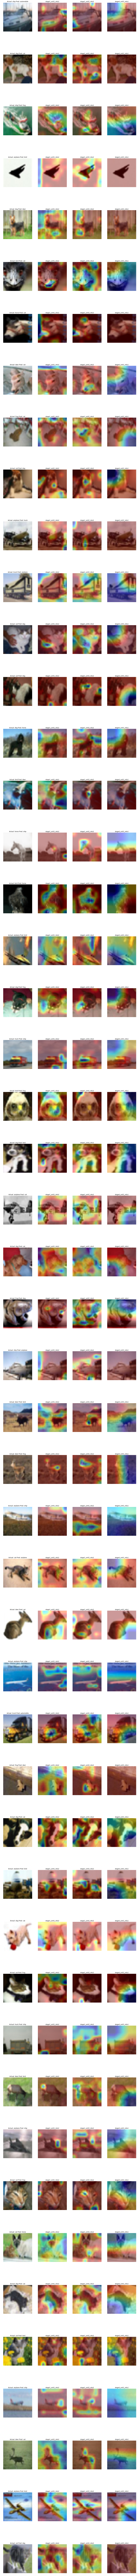

In [0]:
col = 4
row = 50
k = 1

fig = plt.figure(figsize=(20, 400))
for i in misclassified_indexes[:50]:
    print("Image index: ",i)
    temp = x_test[i].copy()
    ax1 = plt.subplot(row, col, k)
    ax1.axis('off')
    ax1.set_title("Actual: "+cifar10_classes[y_test_classes[i]]+" Pred: "+cifar10_classes[y_pred_classes[i]])
    plt.imshow(x_test[i])
    ax2 = plt.subplot(row, col, k+1)
    ax2.axis('off')
    ax2.set_title("stage1_unit1_relu2")
    plt.imshow(get_grad_cam_image_1(temp,model))
    ax3 = plt.subplot(row, col, k+2)
    ax3.axis('off')
    ax3.set_title("stage1_unit2_relu2")
    plt.imshow(get_grad_cam_image_2(temp,model))
    ax4 = plt.subplot(row, col, k+3)
    ax4.axis('off')
    ax4.set_title("stage4_unit1_relu1")
    plt.imshow(get_grad_cam_image_3(temp,model))
    k += 4
plt.show()